In [1]:
%matplotlib inline
import argparse
import glob
import logging
import os
import pickle
import random
import re
import csv
from typing import Dict, List, Tuple
import numpy as np
from scipy import stats
from termcolor import colored
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

## Evaluate on top examples

In [2]:
influence_dir = "new_aws_dirctr_trackin_outputs_bert_full_e3"

In [3]:
data_dir = "resources/processed_dataset/"
micro_train = pickle.load(open(data_dir + "micro_train.pkl", 'rb'))
clean_train = pickle.load(open(data_dir + "clean_train.pkl", 'rb'))
hs_train = pickle.load(open(data_dir + "hs_train.pkl", 'rb'))
micro_adv = pickle.load(open(data_dir + "micro_adv.pkl", 'rb'))

In [4]:
train_dataset = micro_train + clean_train + hs_train
test_dataset = micro_adv

In [5]:
def eval_top_train_ex(test_idx, examine_type='micro', is_control=False, top_percentage=1.0):
    len_micro_train = len(micro_train)
    len_clean_train = len(clean_train)
    influence = pickle.load(open(f"{influence_dir}/influence_test_idx_{test_idx}.pkl", "rb"))
    if np.sum(np.isnan(influence)) > 0:
        return None
    if np.max(influence) == np.min(influence):
        return None
    influence = stats.zscore(influence)
    
    inf_sorted_idx = list(np.argsort(influence))
    inf_sorted_idx.reverse()
    correct_ex_rank = []
    correct_ex_score = []
    correct_ex_count = 0
    for i in range(int(len(influence) * top_percentage)):
        if examine_type == "clean":
            if inf_sorted_idx[i] >= len_micro_train and inf_sorted_idx[i] < len_micro_train + len_clean_train:
                correct_ex_rank.append(i / len(influence) * 100)
                correct_ex_score.append(influence[inf_sorted_idx[i]])
                correct_ex_count += 1
        elif examine_type == "micro":
            if inf_sorted_idx[i] < len_micro_train:
                correct_ex_rank.append(i / len(influence) * 100)
                correct_ex_score.append(influence[inf_sorted_idx[i]])
                correct_ex_count += 1
        elif examine_type == "hateful":
            if inf_sorted_idx[i] >= len_micro_train + len_clean_train:
                correct_ex_rank.append(i / len(influence) * 100)
                correct_ex_score.append(influence[inf_sorted_idx[i]])
                correct_ex_count += 1
        else:
            raise ValueError("Check the size of splitting indices of the train set")
    return correct_ex_rank, correct_ex_score, [correct_ex_count / int(len(influence) * top_percentage)]

avg covert rank: 30.697045249999995
avg non rank: 55.996115562499995
avg overt rank: 45.293492500000006


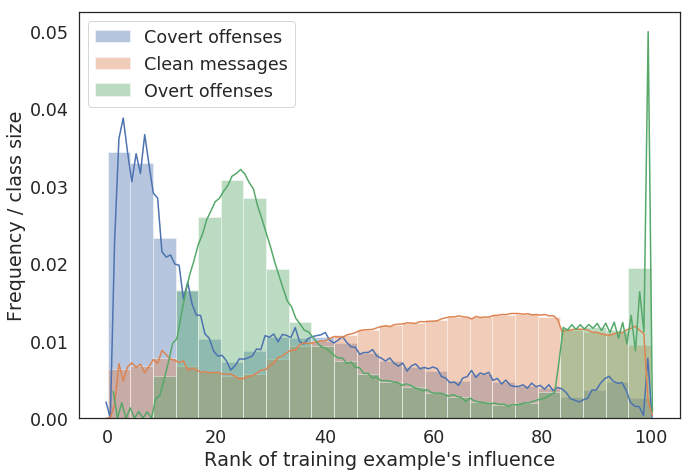

In [6]:
# Default
start_test_idx = 0
end_test_idx = start_test_idx + 100

sns.set_context("paper")
sns.set(style="white", font_scale=1.6)
plt.figure(figsize=(10,7))
bandwidth = 0.1

d = []
_d = []
for test_idx in range(start_test_idx, end_test_idx):
    result = eval_top_train_ex(test_idx)
    if result != None:
        _d.append(result[0])
        for e in result[0]:
            d.append(e)
_d_np = np.array(_d)
ax = sns.distplot(d, label="Covert offenses", bins=np.linspace(0, 100, 25), kde_kws={"bw": bandwidth})
print("avg covert rank:", np.mean(d))

d = []
_d = []
for test_idx in range(start_test_idx, end_test_idx):
    result = eval_top_train_ex(test_idx, examine_type="clean")
    if result != None:
        _d.append(result[0])
        for e in result[0]:
            d.append(e)
_d_np = np.array(_d)
ax = sns.distplot(d, label="Clean messages", bins=np.linspace(0, 100, 25), kde_kws={"bw": bandwidth})
print("avg non rank:", np.mean(d))

d = []
_d = []
for test_idx in range(start_test_idx, end_test_idx):
    result = eval_top_train_ex(test_idx, examine_type="hateful")
    if result != None:
        _d.append(result[0])
        for e in result[0]:
            d.append(e)
_d_np = np.array(_d)
ax = sns.distplot(d, label="Overt offenses", bins=np.linspace(0, 100, 25), kde_kws={"bw": bandwidth})
print("avg overt rank:", np.mean(d))

ax.set(xlabel='Rank of training example\'s influence', ylabel="Frequency / class size")
plt.legend()
plt.tight_layout()
plt.show()

## Find top examples to correct

In [7]:
influence_dir = "new_aws_dirctr_trackin_outputs_bert_full_e3"

In [8]:
data_dir = "resources/processed_dataset/"
micro_train = pickle.load(open(data_dir + "micro_train.pkl", 'rb'))
clean_train = pickle.load(open(data_dir + "clean_train.pkl", 'rb'))
hs_train = pickle.load(open(data_dir + "hs_train.pkl", 'rb'))
micro_adv = pickle.load(open(data_dir + "micro_adv.pkl", 'rb'))

In [9]:
train_dataset = micro_train + clean_train + hs_train
test_dataset = micro_adv

In [10]:
def get_train_ex_mean_rank(start_test_idx, end_test_idx, is_control=False):
    len_micro_train = len(micro_train)
    len_clean_train = len(clean_train)
    train_ex_rank_dict = defaultdict(list)
    for test_idx in range(start_test_idx, end_test_idx):
        influence = pickle.load(open(f"{influence_dir}/influence_test_idx_{test_idx}.pkl", "rb"))
        if np.sum(np.isnan(influence)) > 0:
            return None
        if np.max(influence) == np.min(influence):
            return None
        influence = stats.zscore(influence)
        inf_sorted_idx = list(np.argsort(influence))
        inf_sorted_idx.reverse()
        for rank, train_ex_idx in enumerate(inf_sorted_idx):
            train_ex_rank_dict[train_ex_idx].append(rank / len(influence) * 100)
    return train_ex_rank_dict

macro avg covert rank: 30.697045250000002
macro avg non rank: 55.996115562499995
macro avg overt rank: 45.293492500000006


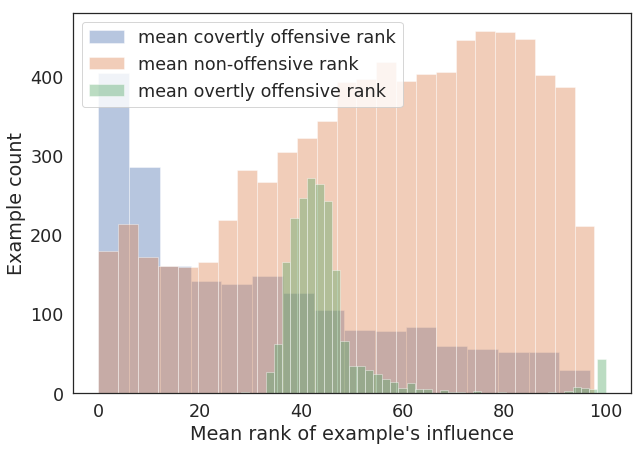

In [11]:
# Default
start_test_idx = 0
end_test_idx = start_test_idx + 100

sns.set_context("paper")
sns.set(style="white", font_scale=1.6)
plt.figure(figsize=(10,7))

train_ex_rank_dict = get_train_ex_mean_rank(start_test_idx, end_test_idx)

d = []
for i in range(0, len(micro_train)):
    d.append(np.mean(train_ex_rank_dict[i]))
ax = sns.distplot(d, label="mean covertly offensive rank", kde=False)
print("macro avg covert rank:", np.mean(d))

d = []
for i in range(len(micro_train), len(micro_train) + len(clean_train)):
    d.append(np.mean(train_ex_rank_dict[i]))
ax = sns.distplot(d, label="mean non-offensive rank", kde=False)
print("macro avg non rank:", np.mean(d))

d = []
for i in range(len(micro_train) + len(clean_train), len(micro_train) + len(clean_train) + len(hs_train)):
    d.append(np.mean(train_ex_rank_dict[i]))
ax = sns.distplot(d, label="mean overtly offensive rank", kde=False)
print("macro avg overt rank:", np.mean(d))

ax.set(xlabel='Mean rank of example\'s influence', ylabel="Example count")
plt.legend()
plt.show()

In [12]:
train_ex_mean_ranks = []
for i in range(len(train_ex_rank_dict)):
    rank_list = train_ex_rank_dict[i]
    train_ex_mean_ranks.append(np.mean(rank_list))
    
sorted_train_ex_by_mean_inf_rank = list(np.argsort(train_ex_mean_ranks))
sorted_train_ex_for_correction = [e for e in sorted_train_ex_by_mean_inf_rank if e < len(micro_train) + len(clean_train)]

In [13]:
for _i in [50, 100, 200, 500, 1000, 1500, 2000]:
    print(sum([1 if e < len(micro_train) else 0 for e in sorted_train_ex_for_correction[:_i]]), '/', _i)

25 / 50
52 / 100
114 / 200
290 / 500
563 / 1000
777 / 1500
961 / 2000
